# Experiments and Hypothesis Testing


<a id="learning-objectives"></a>
## Learning Objectives
*After completing this notebook, you will be able to:*
- Explain the difference between causation and correlation
- Identify sampling bias
- Identify what missing data is and how to handle it
- Test a hypothesis using a sample case study, and calculate sample sizes


## Contents:
* [Covariance](#covariance)
* [Scalars, vectors and matrices](#scalars-vectors-and-matrices)
* [Vector addition and subtraction](#vector-addition)
* [Scalar multiplication](#scalar-multiplication)
* [Dot product](#dot-product)
* [Matrix multiplication](#matrix-multiplication)
* [N-dimensional space](#n-dimensional-space)
* [Vector norms](#vector-norms)
* [Linear algebra in data science](#lin-alg-in-data-science)
* [Our first model](#first-model)


Today, we’ll use advertising data from an example in the book [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/).
- This is a well-known, standard introduction to machine learning.
- The book has a more advanced version — [Elements of Statistical Learning](http://web.stanford.edu/~hastie/ElemStatLearn/) — if you are comfortable with linear algebra and statistics at the graduate level.

<a id="covariance"></a>

# <font color='blue'> Covariance

Covariance is a measure of the joint variability between two random variables.

$$cov(X, Y) = \frac {\sum{(x_i - \bar{X})(y_i - \bar{Y})}} {n}$$

We can gain insight into covariance by looking closely at the formula above. First, observe that the formula effectively pairs the first $x$ data point with the first $y$ data point: $(x_1, y_1)$. All computations are done solely on these pairs of points.

Second, let's ask ourselves, **when would covariance be positive**? 

From the numerator, covariance would be positive if, for all pairs of data points, $(x_i - \bar{X})$ and $(y_i - \bar{Y})$ are 1) both positive or 2) both negative. 

This occurs when: 1) Both data points are greater than their respective means. 

Or when: 2) Both data points are less than their respective means! 

So, if the $x$ data points vary from their mean in the same way the $y$ data points vary from their mean, covariance will be positive.

Third, let's consider: **Might outliers affect covariance?** 

Yes! Given the structure of the formula (a sum of terms), a large outlier pair far from the means could strongly pull the covariance in one direction.

**A Useful Special Case**

The covariance between one variable and itself is just its variance 

$$cov(X, X) = \frac {\sum{(x_i - \bar{X})^2}} {n} = var(X) = \sigma_X^2$$

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# This allows plots to appear directly in the notebook.
%matplotlib inline
plt.style.use('fivethirtyeight') 

In [2]:
# Read data into a DataFrame.
# We use index_col to tell Pandas that the first column in the data has row labels.
advertising_data = pd.read_csv('http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv', index_col=0)
advertising_data.columns = ['tv_spend','radio_spend','newspaper_spend','sales']
advertising_data.head() 


,tv_spend,radio_spend,newspaper_spend,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


This data shows advertising spend (in dollars) spent on TV, radio and newspaper advertising for a single product and corresponding sales of that product in thousands of dollars.

Each row corresponds to a single market (or geography) in which the product was advertised. 

Let's consider the question **on the basis of this data, how should the manufacturer spend its advertising money in future?**

## <font color='red'> Now you try
    
Let's calculate the covariance of `sales` vs `tv_spend`.

(a) Compute the mean sales, $\bar{Y}$

In [3]:
y_mean = advertising_data['sales'].mean()
y_mean

14.022500000000003

(c) Compute the mean TV spend, $\bar{X}$

In [4]:
x_mean = advertising_data['tv_spend'].mean()
x_mean

147.0425

(d) Compute $\sum{(x_i - \bar{X})(y_i - \bar{Y})}$ (hint: you can do this using the dot product)

In [5]:
x_x_mean = advertising_data['tv_spend']-x_mean
y_y_mean = advertising_data['sales']-y_mean

In [6]:
y_y_mean.dot(x_x_mean)

69727.64875

(e) What's $n$ for this dataset?

In [7]:
n=advertising_data.shape[0]

(f) Use the calculations above to get the covariance between TV advertising spend, and sales. 

In [8]:
cov_x_y = y_y_mean.dot(x_x_mean)/n
cov_x_y

348.63824374999996

---

<a id="correlation"></a>

# <font color='blue'> Correlation

While covariance is a useful measure, it can be difficult to compare covariances, as they are not standardized. 

Instead we can use the correlation, which measures the same effect but reports it as a range from -1 to 1. 1 represents perfect covariance and correlation, 0 represents no correlation, and -1 one represents perfect inverse correlation.

$$corr(X,Y) = \frac {cov(X,Y)} {\sigma_X\sigma_Y}$$

Note that the variance is always positive, making the denominator positive. So, the sign of the covariance between $X$ and $Y$ is the same as the sign of their correlation! 

The following visual examples better illustrate how correlation refers to how $X$ and $Y$ change together. Notice that a correlation number by itself is not always indicative of the relationship between the variables — always try to supplement 2-D correlation with a visual!

![](./assets/images/correlation_examples.png)

<a id="variance-covariance-matrix"></a>

# <font color='blue'> The variance-covariance matrix, and correlation matrix

For our purposes in modeling and machine learning, the fastest way to get a preview of the underlying relationships in our data is to use the variance-covariance matrix.

The variance-covariance matrix shows the covariance between every variable in our data set.

Given $n$ features from $X_1$ to $X_n$, the variance-covariance matrix looks like this (recall that $cov(X, X) = var(X)$):

$$\left[ \begin{array}{c}
var(X_1) & cov(X_1,X_2) & ... & cov(X_1,X_n)  \\
cov(X_2,X_1) & var(X_2) & ... & cov(X_2,X_n)  \\
... & ... & ... & ... \\
cov(X_n,X_1) & cov(X_n,X_2) & ... & var(X_n)
\end{array} \right]$$

From a quick glance at this matrix, we can glean insight about which variables might be strongly correlated. This may also indicate redundant features and/or affect some models.

If data are centered around the mean, every column has its mean subtracted from itself. So, the mean for every column is now 0. You can then compute the variance-covariance matrix as:

$$\frac {X^TX} {n}$$

Those of you who have been exposed to linear regression may recognize this term.

To get from the variance-covariance matrix to the correlation matrix, we divide each element by the products of the corresponding standard deviations.

$$\left[ \begin{array}{c}
var(X_1)/\sigma(X_1)^2 & cov(X_1,X_2)/\sigma(X_1)\sigma(X_2) & ... & cov(X_1,X_n)/\sigma(X_1)\sigma(X_n)  \\
cov(X_2,X_1)/\sigma(X_2)\sigma(X_1) & var(X_2)/\sigma(X_2)^2 & ... & cov(X_2,X_n)\sigma(X_2)\sigma(X_n)  \\
... & ... & ... & ... \\
cov(X_n,X_1)/\sigma(X_n)\sigma(X_1) & cov(X_n,X_2)/\sigma(X_n)\sigma(X_2) & ... & var(X_n)/\sigma(X_n)^2
\end{array} \right]$$

---

## <font color='red'> Now you try

(a) Use the answer to the last exercise to find the correlation coefficient between TV spend and sales

In [10]:
y_std = advertising_data['sales'].std()
x_std = advertising_data['tv_spend'].std()

corr_xy = cov_x_y/(x_std*y_std)

corr_xy

0.7783133027372983

(b) Calculate the correlation matrix between all pairs of variables in the advertising dataset, using the DataFrame's built-in `.corr()` method:

In [11]:
advertising_data.corr()

,tv_spend,radio_spend,newspaper_spend,sales
tv_spend,1.000000,0.054809,0.056648,0.782224
radio_spend,0.054809,1.000000,0.354104,0.576223
newspaper_spend,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


When we have a large amount of data, the correlation matrix may be too difficult to read. It can help to make a plot.

(c) Use Seaborn's `.heatmap()` function to make a plot of the correlation matrix. Remember that we imported Seaborn as `sns`.


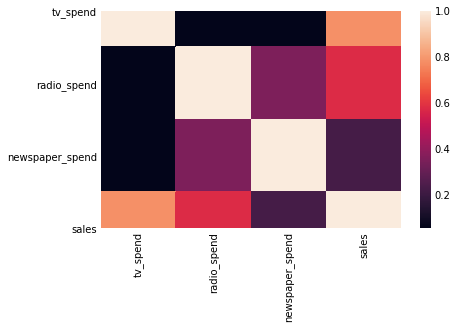

In [12]:
sns.heatmap(advertising_data.corr())

Of course, looking at linear association doesn't show us the whole picture. We can get a more detailed look with a scatterplot matrix.

(d) Use Seaborn's `.pairplot()` function to make joint scatterplots of the data. What do these plots show? What do they tell us about our data? 

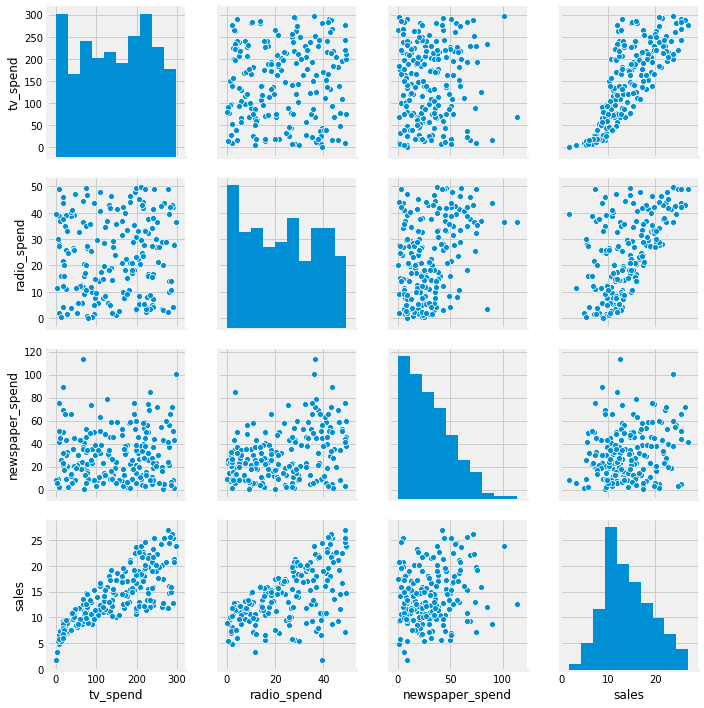

In [14]:
sns.pairplot(advertising_data)


## <font color='red'> Now you try

Read in `us_presidential_votes_clean.csv` and produce a correlation matrix.


Which variables are likely to be the strongest predictors of Trump's vote share?


Do they represent a causal relationship, or are there other factors involved?


Which features look like they're strongly correlated with each other? 

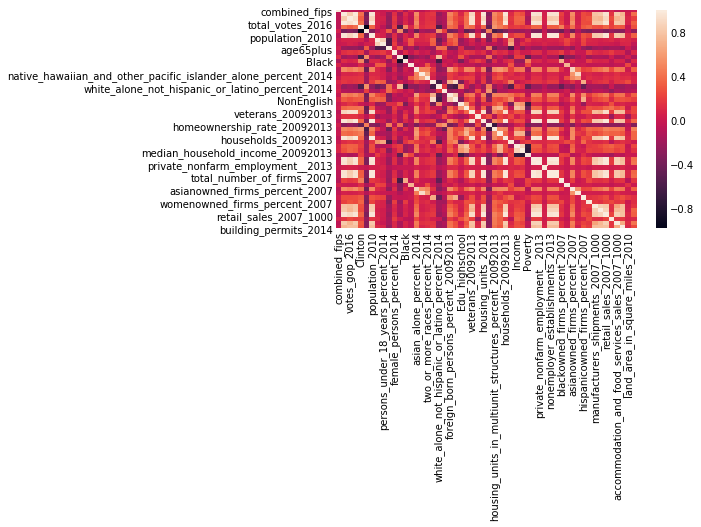

In [15]:
votes = pd.read_csv('./data/us_presidential_votes_clean.csv')
sns.heatmap(votes.corr())

<a id="missing-data"></a>

# <font color='blue'> Missing data

Sometimes we are unable to collect every attribute for a particular observation.

Unfortunately, this makes the observation unusable until we decide how to deal with it.

**We have to decide whether to:**

* Drop the observation.
* Drop the attribute.
* Impute a value for that specific attribute and observation.

## <font color='red'> Now you try
    
Read in the files `missing_data_1.csv`, `missing_data_2.csv`,`missing_data_3.csv`, and `complete_data.csv`.

Each of the first three files shows observations of IQ vs age, with some data missing. For each of these three files, decide whether the data is missing completely at random, missing at random, or missing not at random.

You can use scatter plots, pandas or any other method to help you figure this out.


In [16]:
data1 = pd.read_csv('./data/missing_data_1.csv')
data2 = pd.read_csv('./data/missing_data_2.csv')
data3 = pd.read_csv('./data/missing_data_3.csv')